# Unbinned Profiled Unfolding

In [1]:
%load_ext tensorboard
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
#dvc=device="cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


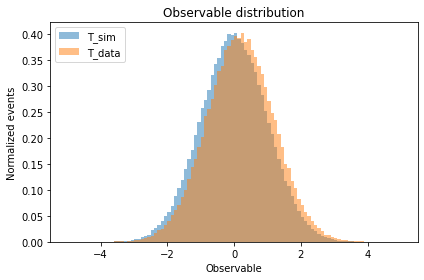

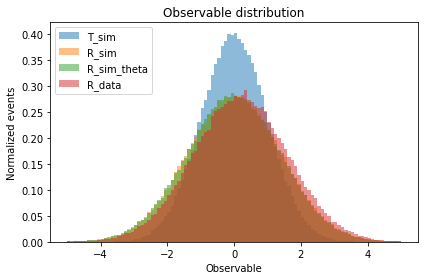

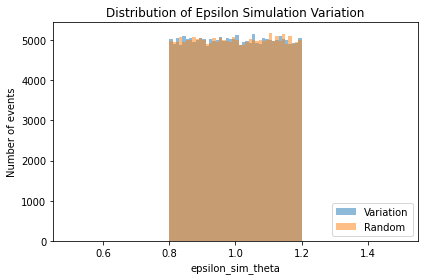

In [2]:
Ndata = 100000
Nsim = 200000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

# simulation with theta variation (theta value randomly sampled)
epsilons_sim_random = np.random.uniform(0.8, 1.2, Nsim) # used for training
epsilons_sim_theta = np.random.uniform(0.8, 1.2, Nsim)
R_sim_theta = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    R_sim_theta.append(np.random.normal(T_sim[i]+beta_sim,epsilons_sim_theta[i]))
R_sim_theta = np.array(R_sim_theta)

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

plt.hist(T_sim, range=(-5, 5), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(T_data, range=(-5, 5), density=True, bins=100, label="T_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(T_sim, range=(-5, 5), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(R_sim, range=(-5, 5), density=True, bins=100, label="R_sim", alpha=0.5)
plt.hist(R_sim_theta, range=(-5, 5), density=True, bins=100, label="R_sim_theta", alpha=0.5)
plt.hist(R_data, range=(-5, 5), density=True, bins=100, label="R_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilons_sim_theta, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.hist(epsilons_sim_random, range=(0.5, 1.5), density=False, bins=100, label="Random", alpha=0.5)
plt.xlabel('epsilon_sim_theta')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [10]:
class w1_dataset(Dataset):
    def __init__(self, T0, R0, R1, epsilon0, epsilon1):
        super(w1_dataset, self).__init__(*args, **kwargs)
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.epsilon0 = epsilon0
        self.epsilon1 = epsilon1
        self.inds = np.random.randint(0,len(R1),len(R0))
        
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 1:
            data = torch.tensor([self.R0[i], self.epsilon0[i], self.T0[i], self.T0[self.inds[i]]]) # use the same T_sim for R_sim variation
        else:
            data = torch.tensor([self.R1[self.inds[i]], self.epsilon1[self.inds[i]], self.T0[i], self.T0[self.inds[i]]])
        return data, label
    
# Do we standardize the input variables?

# class w1_dataset_0(Dataset):
#     def __init__(self, T, R, epsilon):
#         self.T = T
#         self.R = R
#         self.epsilon = epsilon
#         return
        
#     def __len__(self):
#         return len(self.R)

#     def __getitem__(self, idx):
#         data = torch.tensor([self.R[idx], self.epsilon, self.T[idx], self.T[idx]])
#         return data, 1

In [13]:
class w1_network(LightningModule):
    def __init__(self, device="cpu"):
        super(w1_network, self).__init__()
        self.dvc = device
        self.loss_fn = nn.BCELoss()
        self.epoch = 0
        
        # currently using the less constrained model
        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.add_module("linear_1", nn.Linear(4, 50))
        self.linear_relu_stack.add_module("relu_1", nn.ReLU())
        self.linear_relu_stack.add_module("linear_2", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_2", nn.ReLU())
        self.linear_relu_stack.add_module("linear_3", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_3", nn.ReLU())
        self.linear_relu_stack.add_module("linear_4", nn.Linear(50, 1))
        self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def training_epoch_end(self, training_step_outputs):
        self.training_loss = 0
        scores, ys = None, None
        for training_step_output in training_step_outputs:
            self.training_loss += torch.mul(training_step_output["loss"], len(training_step_output["target"])).item()
            scores = torch.cat([scores, training_step_output["score"]]) if scores is not None else training_step_output["score"]
            ys = torch.cat([ys, training_step_output["target"]]) if ys is not None else training_step_output["target"]

        self.training_loss /= len(ys)

        scores = scores.cpu().numpy().reshape(-1)
        ys = ys.cpu().numpy()
        self.training_acc = accuracy_score(ys, scores>0.5)

        self.log("train_loss", self.training_loss)
        self.log("train_acc", self.training_acc)

#         sys.stdout.write('\033[2K\033[1G')
#         sys.stdout.write(f'Epoch {self.epoch}: Train loss - {self.training_loss}, Val loss - {self.validation_loss}\n')
        print("\r"+" "*(os.get_terminal_size().columns-1), end="")
        print("\r"+f'Epoch {self.epoch}: Train loss - {self.training_loss}, Train acc - {self.training_acc}, Val loss - {self.validation_loss}, Val acc - {self.validation_acc}')
        self.epoch += 1

    def validation_epoch_end(self, validation_step_outputs):
        self.validation_loss = 0
        scores, ys = None, None
        for validation_step_output in validation_step_outputs:
#             self.validation_loss += torch.mul(validation_step_output["loss"], len(validation_step_output["target"])).item()
            scores = torch.cat([scores, validation_step_output["score"]]) if scores is not None else validation_step_output["score"]
            ys = torch.cat([ys, validation_step_output["target"]]) if ys is not None else validation_step_output["target"]

#         self.validation_loss /= len(ys)
        self.validation_loss = self.loss_fn(scores, ys.unsqueeze(1).double())

        scores = scores.cpu().numpy().reshape(-1)
        ys = ys.cpu().numpy()
        self.validation_acc = accuracy_score(ys, scores>0.5)

        self.log("val_loss", self.validation_loss)
        self.log("val_acc", self.validation_acc)

    def test_epoch_end(self, test_step_outputs):
        self.test_loss = 0
        scores, ys = None, None
        for test_step_output in test_step_outputs:
            # self.test_loss += torch.mul(test_step_output["loss"], len(test_step_output["target"])).item()
            scores = torch.cat([scores, test_step_output["score"]]) if scores is not None else test_step_output["score"]
            ys = torch.cat([ys, test_step_output["target"]]) if ys is not None else test_step_output["target"]

#         self.test_loss /= len(ys)
        self.test_loss = self.loss_fn(scores, ys.unsqueeze(1).double())

        self.test_scores = scores.cpu().numpy().reshape(-1)
        self.test_ys = ys.cpu().numpy()

        self.log("test_loss", self.test_loss)
        self.test_acc = accuracy_score(self.test_ys, self.test_scores>0.5)

        # sys.stdout.write('Finished. \n')
        # sys.stdout.write(f'Test loss - {self.test_loss} \n')

    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [15]:
w1_ds = w1_dataset(T_sim, R_sim, R_sim_theta, epsilons_sim_random, epsilons_sim_theta)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=1000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=1000, shuffle=False, num_workers=12)

model_w1 = w1_network(device=dvc).double().to(dvc)
print(model_w1)

class LitProgressBar(ProgressBar):
   
    def init_validation_tqdm(self):
        bar = tqdm(            
            disable=True,            
        )
        return bar

bar = LitProgressBar()

callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, check_finite=True), bar]
callbacks.append(ModelCheckpoint(
    save_top_k=1,
    monitor='val_loss',
    mode='min',
    dirpath='model/w1',
    filename='best',
))

trainer = Trainer(accelerator=device, devices=1, callbacks=callbacks, default_root_dir='model/w1')

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/pytorch_lightning/callbacks/progress/progress.py:22: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  "`ProgressBar` has been deprecated in v1.5 and will be removed in v1.7."
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
trainer.fit(model_w1, w1_dataloader_train, w1_dataloader_test)
# !tensorboard --logdir .

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | loss_fn           | BCELoss    | 0     
1 | linear_relu_stack | Sequential | 5.4 K 
-------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /afs/cern.ch/work/c/cchan/UnbinnedProfiledUnfolding/model/w1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Epoch 0: Train loss - 0.5943379404843157, Train acc - 0.6729, Val loss - 0.545506633945431, Val acc - 0.6933                                                                                                                            
Epoch 1: Train loss - 0.5398217796244035, Train acc - 0.69468, Val loss - 0.5425960669516288, Val acc - 0.69377                                                                                                                         
Epoch 2: Train loss - 0.5384820925229354, Train acc - 0.69421, Val loss - 0.5429009742543959, Val acc - 0.69124                                                                                                                         
Epoch 3: Train loss - 0.5370946464326012, Train acc - 0.69524, Val loss - 0.544073475730882, Val acc - 0.68953                                                                                                                          
Epoch 4: Train loss - 0.5370148636524529, Train acc - 0.69492, Val l

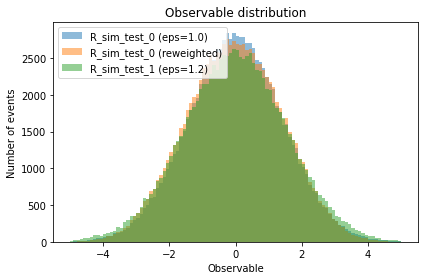

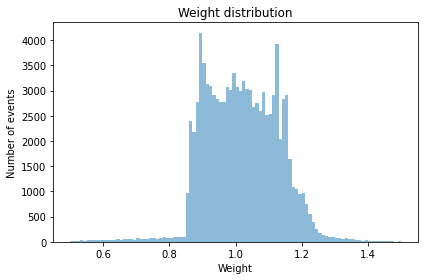

In [19]:
###### TEST W1 PERFORMANCE #####

Nsim = 100000

mu_sim_test = 0
sigma_sim_test = 1
beta_sim_test = 0
epsilon_sim_test_0 = 1
epsilon_sim_test_1 = 1.2

T_sim_test_1 = np.random.normal(mu_sim_test, sigma_sim_test, Nsim)
R_sim_test_1 = np.random.normal(T_sim_test_1 + beta_sim_test, epsilon_sim_test_1)

T_sim_test_0 = np.random.normal(mu_sim_test, sigma_sim_test, Nsim)
R_sim_test_0 = np.random.normal(T_sim_test_0 + beta_sim_test, epsilon_sim_test_0)
x_sim_test_0 = np.c_[R_sim_test_0, np.ones(Nsim) * epsilon_sim_test_1, T_sim_test_0, T_sim_test_0]
x_sim_test_0 = torch.from_numpy(x_sim_test_0).to(dvc)

# print(T_sim_0.shape, R_sim_0.shape)
# w1_ds_0 = w1_dataset_0(T_sim_0, R_sim_0, epsilon_sim_prime)
# w1_dataloader_0 = DataLoader(w1_ds_0, batch_size=64, shuffle=False, num_workers=12)

# load checkpoint
checkpoint = "model/w1/best.ckpt"
model_w1 = w1_network.load_from_checkpoint(checkpoint, device=dvc).double().to(dvc)
model_w1.eval()
scores = model_w1(x_sim_test_0).detach().cpu().numpy().reshape(-1)

# trainer.test(model=model_w1, dataloaders=w1_dataloader_0, ckpt_path=checkpoint)
# scores = model_w1.test_scores
weights = (1. - scores) / scores

plt.hist(R_sim_test_0, range=(-5, 5), density=False, bins=100, label="R_sim_test_0 (eps=1.0)", alpha=0.5)
plt.hist(R_sim_test_0, weights=weights, range=(-5, 5), density=False, bins=100, label="R_sim_test_0 (reweighted)", alpha=0.5)
plt.hist(R_sim_test_1, range=(-5, 5), density=False, bins=100, label="R_sim_test_1 (eps=1.2)", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(weights, range=(0.5, 1.5), density=False, bins=100, label="R_sim", alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Number of events')
plt.title(r'Weight distribution')
# plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()

In [3]:
class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        self.R = R
        self.T = T
        
    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.tensor([self.T[idx]]), torch.tensor([self.R[idx]])

In [4]:
class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, device="cpu"):
        super(NLLLoss, self).__init__()
        self.dvc = device
        if type(obs_data) == torch.Tensor:
            self.obs_data = obs_data.float().to(self.dvc)
        elif type(obs_data) == np.ndarray:
            self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        elif type(obs_data) == list:
            self.obs_data = torch.tensor(obs_data).float().to(self.dvc)
        if type(bins) == torch.Tensor:
            self.bins = bins.float().to(self.dvc)
        elif type(bins) == np.ndarray:
            self.bins = torch.from_numpy(bins).float().to(self.dvc)
        elif type(bins) == list:
            self.bins = torch.tensor(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R = torch.cat((h_R, torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1))) if h_R != None else torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
        nll = torch.neg(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum()) # + log_gauss
        return nll
    
# log_gauss(test_epsilon,epsilon_sim*0.1,epsilon_sim)
    
# def log_gauss(x,sigma,mu):
#     return -0.5*(x-mu)**2/sigma**2

In [5]:
class w0_network(nn.Module):
    def __init__(self):
        super(w0_network, self).__init__()
            
        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.add_module("linear_1", nn.Linear(1, 50))
        self.linear_relu_stack.add_module("relu_1", nn.ReLU())
        self.linear_relu_stack.add_module("linear_2", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_2", nn.ReLU())
        self.linear_relu_stack.add_module("linear_3", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_3", nn.ReLU())
        self.linear_relu_stack.add_module("linear_4", nn.Linear(50, 1))
#         self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        weights_0 = self.linear_relu_stack(T)
        weights_0 = torch.exp(weights_0)
        return weights_0
    
class w1_analytic(nn.Module):
    
    def __init__(self, epsilon, beta, d):
        super(w1_analytic, self).__init__()
        self.epsilon = epsilon
        self.beta = beta
        self.d = d
        
    def forward(self, T, R, c):
        return (c/self.epsilon)*torch.exp(-0.5*(R-T-self.d)**2/c**2+0.5*(R-T-self.beta)**2/self.epsilon**2)


In [6]:
def train_w0(train_dataloader, val_dataloader, model_w0, model_w1, loss_fn, optimizer, max_epoch=100, patience=10):
    
    print("===================== Model W0 =====================")
    print(model_w0)
    print("===================== Model W1 =====================")
    print(model_w1)
    
    best_state = model_w0.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    print("====================================================")
    print(" Start optimizing the W0 model and theta")
    print("====================================================")
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w0.train()
        for batch, (T, R) in enumerate(train_dataloader):
            T, R = T.to(dvc), R.to(dvc)

            # Compute weights
            W = model_w0(T) * model_w1(T, R, torch.tensor(1.))
            loss = loss_fn(R, W)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
        # now evaluate performance at the epoch end
        model_w0.eval()
        
        # evaluate loss for traing set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(train_dataloader):
                T, R = T.to(dvc), R.to(dvc)

                # Compute weights
                W = model_w0(T) * model_w1(T, R, torch.tensor(1.))
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            train_loss = loss_fn(Rs, Ws)
            
        # evaluate loss for validation set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(val_dataloader):
                T, R = T.to(dvc), R.to(dvc)

                # Compute weights
                W = model_w0(T) * model_w1(T, R, torch.tensor(1.))
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            val_loss = loss_fn(Rs, Ws)
        
        print("\r" + " "*(50), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w0.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            model_w0.load_state_dict(best_state)
            break
        
        
def test_w0(test_dataloader, model_w0, model_w1, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)

            # Compute weights
            W0 = model_w0(T)
            W1 = model_w1(T, R, torch.tensor(1.))
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s


In [38]:
class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", header="Gaussian Example", density=True, save_name=None):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel("Data/Pred.",fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc="upper left")
        self.save()
        plt.show()
        plt.clf()

In [12]:
w0_ds = w0_dataset(T_sim, R_sim)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)
w1_model_analytic = w1_analytic(1., 0., 0.).double().to(dvc)
loss_fn = NLLLoss(R_data, np.linspace(-5,5,20), device=dvc)

In [24]:
### PLEASE ENTER A NEW MODEL NAME FOR W0 ###
w0_model_name = 'w0_v1_09282022'

w0_model_network = w0_network().double().to(dvc)
optimizer = optim.Adam(w0_model_network.parameters())
train_w0(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1_model_analytic, loss_fn, optimizer)
torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_1): Linear(in_features=1, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=50, bias=True)
    (relu_3): ReLU()
    (linear_4): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1 =====================
w1_analytic()
 Start optimizing the W0 model and theta
[Epoch   0] [Train_loss: -807666.052178] [Val_loss: -807565.816523]
[Epoch   1] [Train_loss: -808227.611039] [Val_loss: -808135.008991]
[Epoch   2] [Train_loss: -808656.161315] [Val_loss: -808570.629265]
[Epoch   3] [Train_loss: -808965.180264] [Val_loss: -808885.796936]
[Epoch   4] [Train_loss: -809178.914767] [Val_loss: -809105.019597]
[Epoch   5] [Train_loss: -809335.789174] [Val_loss: -809267.614966]
[Epoch   6] [Train_loss: -809442.666184] [Val_los

[Test_loss: -809452.625005]


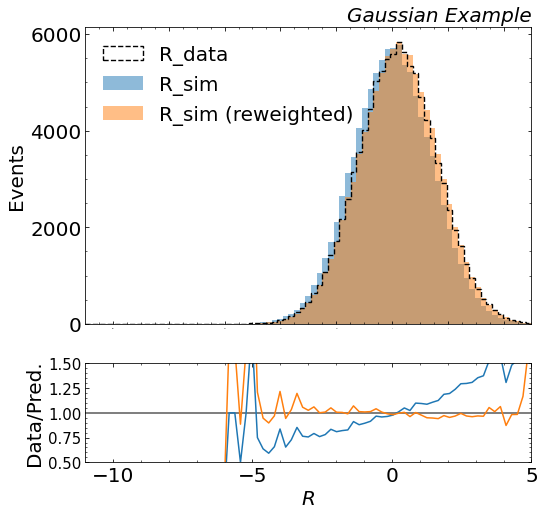

<Figure size 432x288 with 0 Axes>

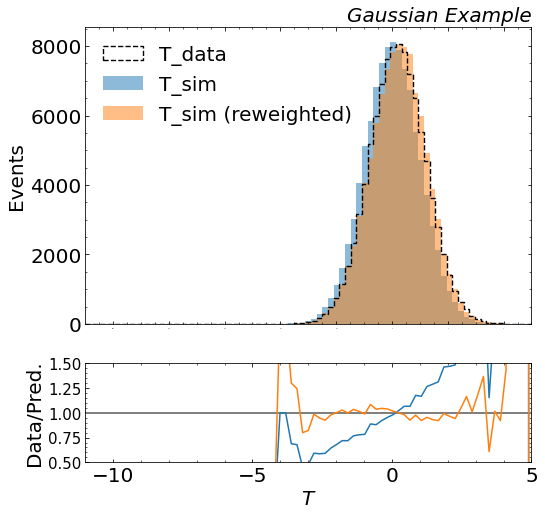

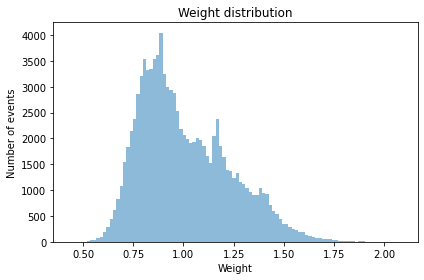

In [39]:
w0_model_network = torch.load('model/w0/w0_v1_09282022.pth')

Ts, Rs, Ws, W0s, W1s = test_w0(w0_dataloader_test, w0_model_network, w1_model_analytic, loss_fn)
Ts, Rs, Ws, W0s, W1s = Ts.cpu().numpy(), Rs.cpu().numpy(), Ws.cpu().numpy(), W0s.cpu().numpy(), W1s.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 5, 80, xlabel=r"$R$", density=False, save_name="Compare_R_09282022")
cpwr.add_data(R_data, label="R_data", target=True, color='black', histtype="step", ls="--", lw=1.4)
cpwr.add_data(Rs, label="R_sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs, weights=Ws, label="R_sim (reweighted)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 5, 80, xlabel=r"$T$", density=False, save_name="Compare_T_09282022")
cpwr.add_data(T_data, label="T_data", target=True, color='black', histtype="step", ls="--", lw=1.4)
cpwr.add_data(Ts, label="T_sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts, weights=W0s, label="T_sim (reweighted)", alpha=0.5, color='tab:orange')
cpwr.show()

plt.hist(Ws, density=False, bins=100, label="R_sim", alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Number of events')
plt.title(r'Weight distribution')
# plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()